In this exercise, we implement the Quantum equivalent of the Convolutional Neural Network. Similar to the Iris classification, we make a Convolutional block as a Quantum circuit. In this Quanvolutional block, a kernel of size 2x2 is taken for MNIST digit classification. In the given example, we use the dilation of 1 and stride of 2. This leads to conversion of the original 28x28 image of digit into 4 14x14 images. 4 images because of each image for each of the pixels in the kernel. Further, the layer has a randomly created circuit using PennyLane's in-built function for the same. We then initialize the layer(s) with random weights, which are fine-tuned after each iteration.

For the classical part, we use a Feed Forward Network and apply the Softmax function for final classification of the input images into 10 different classes, one for each digit from 0 to 9.

The classification algorithm is similar to the usual CNN, with the change of using the Quanvolutional layer instead of the usual Convolutional block. This helps in saving a lot of parameters.

In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [26]:
n_epochs = 50
n_layers = 1
n_train = 50
n_test = 30

SAVE_PATH = "./data/"
PREPROCESS = True
np.random.seed(0)
tf.random.set_seed(0)

In [27]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

train_images = train_images / 255
test_images = test_images / 255

In [28]:
train_images = np.array(train_images[..., tf.newaxis], requires_grad=True)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=True)

### Quantum Convolutional Kernel

In [29]:
dev = qml.device('default.qubit', wires=4)

In [30]:
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi*phi[j], wires=j)
    
    RandomLayers(rand_params, wires=list(range(4)))
    
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

The function below does the kernel operation by using the ciruit function defined above. It assigns the pixel values as rotation values to the 4 qubits. After qubit rotation, the RandomLayers operation is used to randomly create a Variational circuit.

As the output, the function gives the output of shape (14, 14, 4). Out of this, the two 14s are because of the kernel size, dilation and stride parameters. The 4 in the shape is because of the design of the circuit. In this case, it is because of the total number of pixels in the kernel.

In [31]:
def quanv(image):
    out = np.zeros((14, 14, 4))
    
    for x in range(0, 28, 2):
        for y in range(0, 28, 2):
            q_results = circuit(
            [
                image[x, y, 0],
                image[x, y + 1, 0],
                image[x + 1, y + 1, 0],
                image[x + 1, y, 0]
            ])
            
            for c in range(4):
                out[x // 2, y // 2, c] = q_results[c]
    
    return out

In [32]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


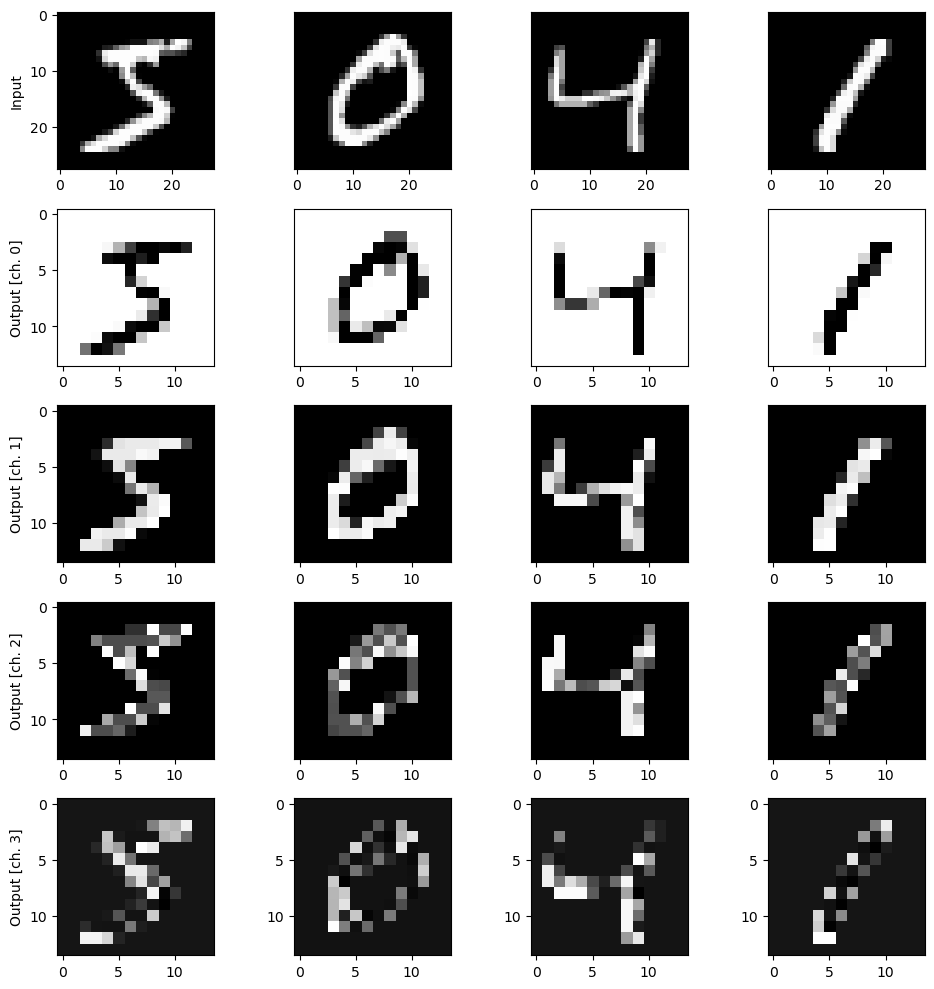

In [33]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

The function below defines the FFN for the classical inference of the output generated by the QNN.

In [34]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [35]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/50
13/13 - 0s - 21ms/step - accuracy: 0.1000 - loss: 2.7136 - val_accuracy: 0.2000 - val_loss: 2.2633
Epoch 2/50
13/13 - 0s - 1ms/step - accuracy: 0.4000 - loss: 1.8416 - val_accuracy: 0.2667 - val_loss: 2.1395
Epoch 3/50
13/13 - 0s - 1ms/step - accuracy: 0.6400 - loss: 1.5288 - val_accuracy: 0.3333 - val_loss: 1.8936
Epoch 4/50
13/13 - 0s - 1ms/step - accuracy: 0.7800 - loss: 1.2211 - val_accuracy: 0.3667 - val_loss: 1.7599
Epoch 5/50
13/13 - 0s - 1ms/step - accuracy: 0.9000 - loss: 0.9960 - val_accuracy: 0.4000 - val_loss: 1.6556
Epoch 6/50
13/13 - 0s - 1ms/step - accuracy: 0.9200 - loss: 0.8210 - val_accuracy: 0.4000 - val_loss: 1.5571
Epoch 7/50
13/13 - 0s - 1ms/step - accuracy: 0.9600 - loss: 0.6846 - val_accuracy: 0.5000 - val_loss: 1.4764
Epoch 8/50
13/13 - 0s - 1ms/step - accuracy: 0.9800 - loss: 0.5772 - val_accuracy: 0.5000 - val_loss: 1.4126
Epoch 9/50
13/13 - 0s - 1ms/step - accuracy: 0.9800 - loss: 0.4903 - val_accuracy: 0.6000 - val_loss: 1.3582
Epoch 10/50
13/13 

In [36]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/50
13/13 - 0s - 15ms/step - accuracy: 0.1000 - loss: 2.3906 - val_accuracy: 0.1333 - val_loss: 2.2829
Epoch 2/50
13/13 - 0s - 1ms/step - accuracy: 0.3600 - loss: 1.9667 - val_accuracy: 0.2333 - val_loss: 2.0894
Epoch 3/50
13/13 - 0s - 1ms/step - accuracy: 0.5800 - loss: 1.6685 - val_accuracy: 0.3000 - val_loss: 1.9270
Epoch 4/50
13/13 - 0s - 1ms/step - accuracy: 0.8000 - loss: 1.4246 - val_accuracy: 0.5333 - val_loss: 1.7890
Epoch 5/50
13/13 - 0s - 1ms/step - accuracy: 0.8600 - loss: 1.2221 - val_accuracy: 0.6000 - val_loss: 1.6742
Epoch 6/50
13/13 - 0s - 1ms/step - accuracy: 0.9200 - loss: 1.0545 - val_accuracy: 0.6333 - val_loss: 1.5806
Epoch 7/50
13/13 - 0s - 1ms/step - accuracy: 0.9600 - loss: 0.9161 - val_accuracy: 0.6333 - val_loss: 1.5044
Epoch 8/50
13/13 - 0s - 2ms/step - accuracy: 0.9600 - loss: 0.8014 - val_accuracy: 0.6333 - val_loss: 1.4416
Epoch 9/50
13/13 - 0s - 1ms/step - accuracy: 0.9800 - loss: 0.7056 - val_accuracy: 0.6333 - val_loss: 1.3890
Epoch 10/50
13/13 

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_10883/925943430.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


NameError: name 'q_history' is not defined

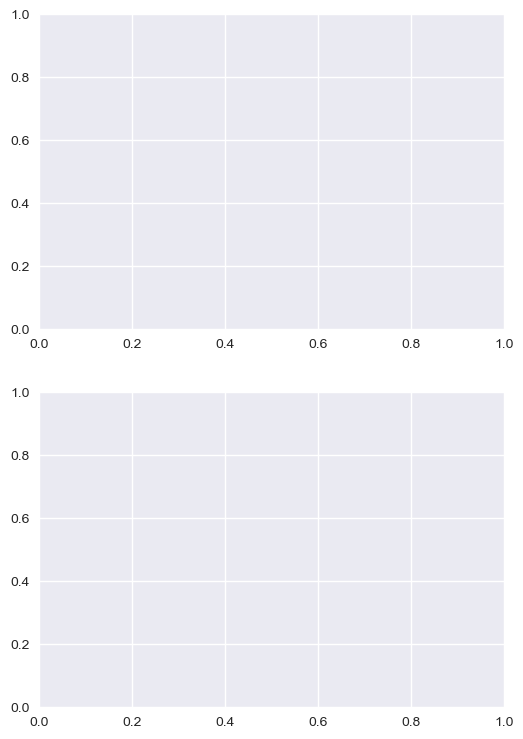

In [1]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()